# CSE251B Project Milestone Starter File

## Step 1: Import Dependencies:

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.data import Data, Batch
import tqdm

## Step 2: Load the Dataset

#### You need to describe in your own words what the dataset is about, and use mathematical language and formulate your prediction task on the submitted PDF file for Question 1 Problem A.

#### Here we are loading the dataset from the local directory. And answer Question 1 Problem B

In [39]:
train_npz = np.load('./train.npz')
train_data = train_npz['data']
test_npz  = np.load('./test_input.npz')
test_data  = test_npz['data']

In [40]:
print(train_data.shape, test_data.shape)

# Split once for later use
X_train = train_data[..., :50, :]
Y_train = train_data[:, 0, 50:, :2]

(10000, 50, 110, 6) (2100, 50, 50, 6)


In [41]:
def plot_heatmap(data, title=None, bins=5):
    plt.figure(figsize=(6, 6))

    x_max = data[..., 0].max()
    x_min = data[..., 0].min()
    y_max = data[..., 1].max()
    y_min = data[..., 1].min()

    plt.hist2d(data[:, 0], data[:, 1], bins=bins, cmap='hot')
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.title(title)
    plt.colorbar(label='Density')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.show()

In [42]:
xy_in = train_data[:, :, :50, :2].reshape(-1, 2)
# only find the x, y != 0
xy_in_not_0 = xy_in[(xy_in[:, 0] != 0) & (xy_in[:, 1] != 0)]

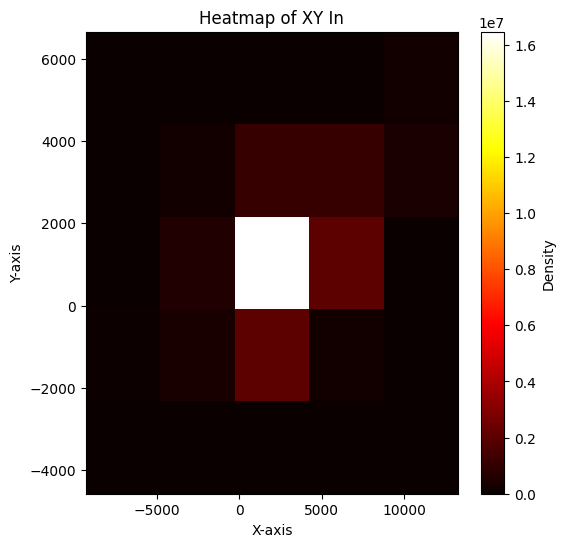

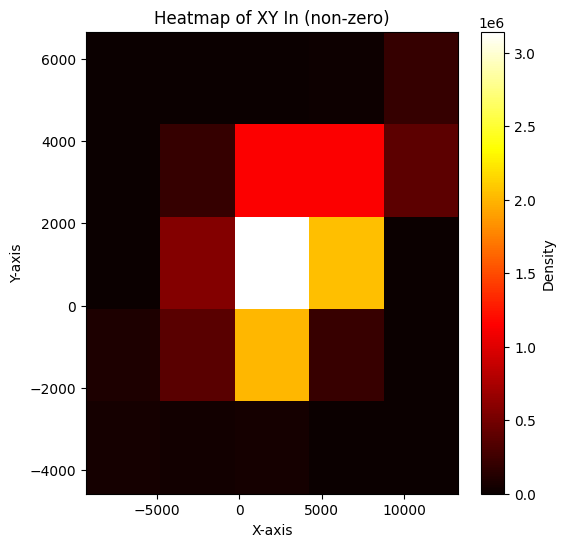

In [43]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=5)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=5)

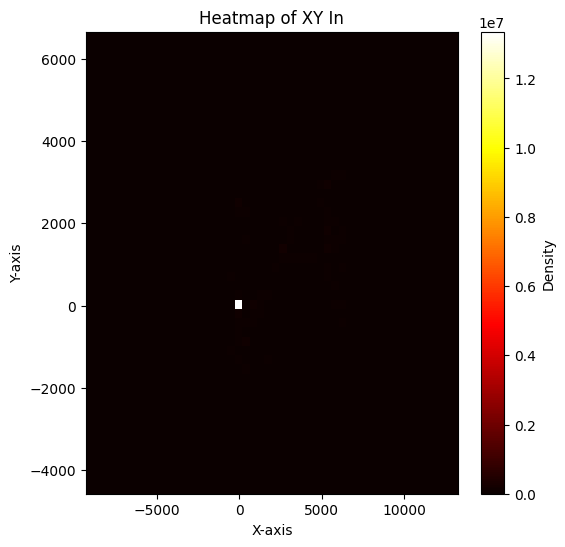

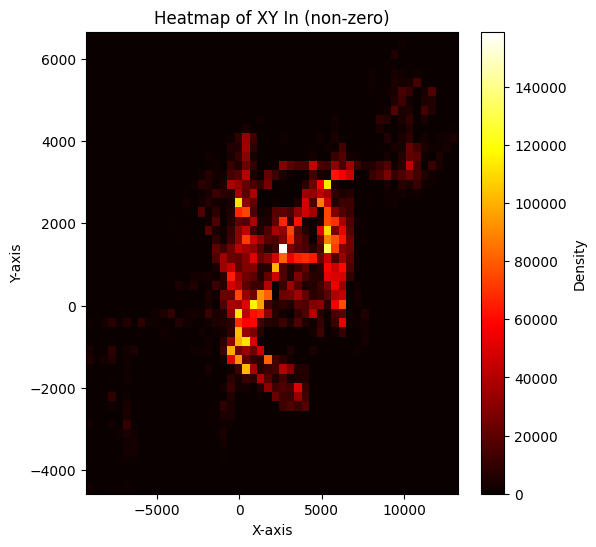

In [44]:
plot_heatmap(xy_in, title='Heatmap of XY In', bins=50)
plot_heatmap(xy_in_not_0, title='Heatmap of XY In (non-zero)', bins=50)

#### Try to play around with dataset for training and testing, make exploratory analysis on the dataset for bonus points(up to 2)

## Step 3: Setting up the Training and Testing

### Example Code:

In [45]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                future = future @ R
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        future = future - origin

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

#### Answer Question related to Your Computational Platform and GPU for Question 2 Problem A

In [46]:
torch.manual_seed(251)
np.random.seed(42)

scale = 5.0

N = len(train_data)
val_size = int(0.1 * N)
train_size = N - val_size

train_dataset = TrajectoryDatasetTrain(train_data[:train_size], scale=scale, augment=True)
val_dataset = TrajectoryDatasetTrain(train_data[train_size:], scale=scale, augment=False)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=lambda x: Batch.from_data_list(x))
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=False, collate_fn=lambda x: Batch.from_data_list(x))

# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')

Using Apple Silicon GPU


In [47]:
class LSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=256, output_dim=60 * 2):
        super(LSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x = data.x
        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class InteractionAwareLSTM(nn.Module):
    def __init__(self, input_dim=6, hidden_dim=256, output_dim=60*2, num_agents=50):
        super(InteractionAwareLSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_agents = num_agents
        
        # Shared LSTM for processing all agents' trajectories
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        
        # Attention mechanism to combine agents' influences
        self.attention = nn.MultiheadAttention(hidden_dim, num_heads=4, batch_first=True)
        
        # Final prediction layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # x2 for ego + context

    def forward(self, data):
        x = data.x
        x = x.reshape(-1, 50, 6)
        
        lstm_out, _ = self.lstm(x)  # (B*N, 50, H)
        last_hidden = lstm_out[:, -1, :].view(x.shape[0] // 50, self.num_agents, self.hidden_dim)
        
        # Separate ego features and other agents
        ego_hidden = last_hidden[:, 0, :].unsqueeze(1)  # (B, 1, H)
        others_hidden = last_hidden[:, 1:, :]  # (B, N-1, H)
        
        context, _ = self.attention(
            ego_hidden, others_hidden, others_hidden,
            need_weights=False
        )
        
        # Combine ego features with context
        combined = torch.cat([ego_hidden.squeeze(1), context.squeeze(1)], dim=1)
        
        # Final prediction
        out = self.fc(combined)
        
        return out.view(-1, 60, 2)

#### Your Optimizer and Hyperparameters for Question 2 Problem A (Try to use different optimizers and hyperparameters for your model and see how it affects the performance of your model)

In [49]:
# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)
model = InteractionAwareLSTM().to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.25) # You can try different schedulers

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=5) # can change factor to 0.7 of 8.04
early_stopping_patience = 30 # can change to 15 for 8.04
best_val_loss = float('inf')
no_improvement = 0
criterion = nn.MSELoss()

#### Using the Simple Linear Regression Model for Question 2B and Visualize the validation loss(MAE) (Hint: You should adapt the code for training loss and try to draw graphs as specified in the project description)

In [50]:
for epoch in tqdm.tqdm(range(200), desc="Epoch", unit="epoch"):
    # ---- Training ----
    model.train()
    train_loss = 0
    for batch in train_dataloader:
        batch = batch.to(device)
        pred = model(batch)
        y = batch.y.view(batch.num_graphs, 60, 2)
        loss = criterion(pred, y)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
        optimizer.step()
        train_loss += loss.item()
    
    # ---- Validation ----
    model.eval()
    val_loss = 0
    val_mae = 0
    val_mse = 0
    with torch.no_grad():
        for batch in val_dataloader:
            batch = batch.to(device)
            pred = model(batch)
            y = batch.y.view(batch.num_graphs, 60, 2)
            val_loss += criterion(pred, y).item()

            # show MAE and MSE with unnormalized data
            pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            y = y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
            val_mae += nn.L1Loss()(pred, y).item()
            val_mse += nn.MSELoss()(pred, y).item()
    
    train_loss /= len(train_dataloader)
    val_loss /= len(val_dataloader)
    val_mae /= len(val_dataloader)
    val_mse /= len(val_dataloader)
    # scheduler.step()
    scheduler.step(val_loss)
    
    tqdm.tqdm.write(f"Epoch {epoch:03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")
    if val_loss < best_val_loss - 1e-3:
        best_val_loss = val_loss
        no_improvement = 0
        torch.save(model.state_dict(), "best_model.pt")
    else:
        no_improvement += 1
        if no_improvement >= early_stopping_patience:
            print("Early stop!")
            break

Epoch:   0%|          | 0/200 [00:00<?, ?epoch/s]/var/folders/c3/nf0b8q01303dvc7nr1m9s8fw0000gn/T/ipykernel_50228/3713195397.py:30: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future @ R
/var/folders/c3/nf0b8q01303dvc7nr1m9s8fw0000gn/T/ipykernel_50228/3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin
Epoch:   0%|          | 1/200 [00:27<1:31:43, 27.66s/epoch]

Epoch 000 | Learning rate 0.001000 | train normalized MSE   4.2673 | val normalized MSE   1.4547, | val MAE   3.4004 | val MSE  36.3674


Epoch:   1%|          | 2/200 [00:55<1:31:04, 27.60s/epoch]

Epoch 001 | Learning rate 0.001000 | train normalized MSE   1.0608 | val normalized MSE   0.7906, | val MAE   2.4290 | val MSE  19.7660


Epoch:   2%|▏         | 3/200 [01:22<1:29:45, 27.34s/epoch]

Epoch 002 | Learning rate 0.001000 | train normalized MSE   0.7925 | val normalized MSE   0.8442, | val MAE   2.6538 | val MSE  21.1057


Epoch:   2%|▏         | 4/200 [01:49<1:29:20, 27.35s/epoch]

Epoch 003 | Learning rate 0.001000 | train normalized MSE   0.7270 | val normalized MSE   0.7334, | val MAE   2.3156 | val MSE  18.3351


Epoch:   2%|▎         | 5/200 [02:17<1:29:15, 27.47s/epoch]

Epoch 004 | Learning rate 0.001000 | train normalized MSE   0.6365 | val normalized MSE   0.5995, | val MAE   2.0814 | val MSE  14.9866


Epoch:   3%|▎         | 6/200 [02:44<1:28:23, 27.34s/epoch]

Epoch 005 | Learning rate 0.001000 | train normalized MSE   0.6062 | val normalized MSE   0.5870, | val MAE   2.0298 | val MSE  14.6757


Epoch:   4%|▎         | 7/200 [03:12<1:28:16, 27.44s/epoch]

Epoch 006 | Learning rate 0.001000 | train normalized MSE   0.5522 | val normalized MSE   0.5486, | val MAE   1.9346 | val MSE  13.7162


Epoch:   4%|▍         | 8/200 [03:39<1:27:23, 27.31s/epoch]

Epoch 007 | Learning rate 0.001000 | train normalized MSE   0.5472 | val normalized MSE   0.5142, | val MAE   1.8991 | val MSE  12.8544


Epoch:   4%|▍         | 9/200 [04:06<1:26:40, 27.23s/epoch]

Epoch 008 | Learning rate 0.001000 | train normalized MSE   0.5114 | val normalized MSE   0.4958, | val MAE   1.7771 | val MSE  12.3958


Epoch:   5%|▌         | 10/200 [04:33<1:26:35, 27.35s/epoch]

Epoch 009 | Learning rate 0.001000 | train normalized MSE   0.4926 | val normalized MSE   0.4778, | val MAE   1.7865 | val MSE  11.9462


Epoch:   6%|▌         | 11/200 [05:00<1:25:23, 27.11s/epoch]

Epoch 010 | Learning rate 0.001000 | train normalized MSE   0.4993 | val normalized MSE   0.5587, | val MAE   1.9569 | val MSE  13.9684


Epoch:   6%|▌         | 12/200 [05:26<1:23:59, 26.81s/epoch]

Epoch 011 | Learning rate 0.001000 | train normalized MSE   0.4898 | val normalized MSE   0.4797, | val MAE   1.8012 | val MSE  11.9925


Epoch:   6%|▋         | 13/200 [05:52<1:22:50, 26.58s/epoch]

Epoch 012 | Learning rate 0.001000 | train normalized MSE   0.4754 | val normalized MSE   0.4717, | val MAE   1.7747 | val MSE  11.7919


Epoch:   7%|▋         | 14/200 [06:18<1:22:13, 26.52s/epoch]

Epoch 013 | Learning rate 0.001000 | train normalized MSE   0.4556 | val normalized MSE   0.4508, | val MAE   1.6528 | val MSE  11.2702


Epoch:   8%|▊         | 15/200 [06:44<1:21:21, 26.39s/epoch]

Epoch 014 | Learning rate 0.001000 | train normalized MSE   0.4509 | val normalized MSE   0.4650, | val MAE   1.7558 | val MSE  11.6243


Epoch:   8%|▊         | 16/200 [07:11<1:20:40, 26.31s/epoch]

Epoch 015 | Learning rate 0.001000 | train normalized MSE   0.4437 | val normalized MSE   0.4189, | val MAE   1.5812 | val MSE  10.4736


Epoch:   8%|▊         | 17/200 [07:37<1:20:13, 26.30s/epoch]

Epoch 016 | Learning rate 0.001000 | train normalized MSE   0.4377 | val normalized MSE   0.4562, | val MAE   1.7181 | val MSE  11.4048


Epoch:   9%|▉         | 18/200 [08:03<1:19:25, 26.19s/epoch]

Epoch 017 | Learning rate 0.001000 | train normalized MSE   0.4313 | val normalized MSE   0.4375, | val MAE   1.6285 | val MSE  10.9364


Epoch:  10%|▉         | 19/200 [08:29<1:19:06, 26.22s/epoch]

Epoch 018 | Learning rate 0.001000 | train normalized MSE   0.4337 | val normalized MSE   0.4181, | val MAE   1.6789 | val MSE  10.4514


Epoch:  10%|█         | 20/200 [08:55<1:18:32, 26.18s/epoch]

Epoch 019 | Learning rate 0.001000 | train normalized MSE   0.4258 | val normalized MSE   0.4250, | val MAE   1.6872 | val MSE  10.6253


Epoch:  10%|█         | 21/200 [09:21<1:17:58, 26.14s/epoch]

Epoch 020 | Learning rate 0.001000 | train normalized MSE   0.4294 | val normalized MSE   0.4090, | val MAE   1.6210 | val MSE  10.2257


Epoch:  11%|█         | 22/200 [09:47<1:17:32, 26.14s/epoch]

Epoch 021 | Learning rate 0.001000 | train normalized MSE   0.4121 | val normalized MSE   0.4331, | val MAE   1.6855 | val MSE  10.8270


Epoch:  12%|█▏        | 23/200 [10:13<1:17:08, 26.15s/epoch]

Epoch 022 | Learning rate 0.001000 | train normalized MSE   0.4020 | val normalized MSE   0.4141, | val MAE   1.6542 | val MSE  10.3516


Epoch:  12%|█▏        | 24/200 [10:40<1:17:02, 26.26s/epoch]

Epoch 023 | Learning rate 0.001000 | train normalized MSE   0.3974 | val normalized MSE   0.4134, | val MAE   1.6324 | val MSE  10.3343


Epoch:  12%|█▎        | 25/200 [11:07<1:17:07, 26.44s/epoch]

Epoch 024 | Learning rate 0.001000 | train normalized MSE   0.4025 | val normalized MSE   0.4314, | val MAE   1.7121 | val MSE  10.7851


Epoch:  13%|█▎        | 26/200 [11:33<1:16:30, 26.38s/epoch]

Epoch 025 | Learning rate 0.001000 | train normalized MSE   0.4016 | val normalized MSE   0.3966, | val MAE   1.5690 | val MSE   9.9158


Epoch:  14%|█▎        | 27/200 [12:00<1:16:31, 26.54s/epoch]

Epoch 026 | Learning rate 0.001000 | train normalized MSE   0.3934 | val normalized MSE   0.4291, | val MAE   1.6609 | val MSE  10.7274


Epoch:  14%|█▍        | 28/200 [12:26<1:15:54, 26.48s/epoch]

Epoch 027 | Learning rate 0.001000 | train normalized MSE   0.3900 | val normalized MSE   0.3895, | val MAE   1.5445 | val MSE   9.7386


Epoch:  14%|█▍        | 29/200 [12:52<1:14:54, 26.28s/epoch]

Epoch 028 | Learning rate 0.001000 | train normalized MSE   0.3848 | val normalized MSE   0.4098, | val MAE   1.6226 | val MSE  10.2454


Epoch:  15%|█▌        | 30/200 [13:18<1:14:22, 26.25s/epoch]

Epoch 029 | Learning rate 0.001000 | train normalized MSE   0.3767 | val normalized MSE   0.4124, | val MAE   1.6390 | val MSE  10.3092


Epoch:  16%|█▌        | 31/200 [13:44<1:13:48, 26.21s/epoch]

Epoch 030 | Learning rate 0.001000 | train normalized MSE   0.3872 | val normalized MSE   0.3997, | val MAE   1.6402 | val MSE   9.9933


Epoch:  16%|█▌        | 32/200 [14:11<1:13:26, 26.23s/epoch]

Epoch 031 | Learning rate 0.001000 | train normalized MSE   0.3746 | val normalized MSE   0.4212, | val MAE   1.6398 | val MSE  10.5295


Epoch:  16%|█▋        | 33/200 [14:37<1:12:55, 26.20s/epoch]

Epoch 032 | Learning rate 0.001000 | train normalized MSE   0.3700 | val normalized MSE   0.3983, | val MAE   1.6265 | val MSE   9.9571


Epoch:  17%|█▋        | 34/200 [15:03<1:12:42, 26.28s/epoch]

Epoch 033 | Learning rate 0.001000 | train normalized MSE   0.3684 | val normalized MSE   0.3829, | val MAE   1.5914 | val MSE   9.5729


Epoch:  18%|█▊        | 35/200 [15:29<1:12:08, 26.23s/epoch]

Epoch 034 | Learning rate 0.001000 | train normalized MSE   0.3569 | val normalized MSE   0.3748, | val MAE   1.5475 | val MSE   9.3705


Epoch:  18%|█▊        | 36/200 [15:57<1:12:45, 26.62s/epoch]

Epoch 035 | Learning rate 0.001000 | train normalized MSE   0.3626 | val normalized MSE   0.3893, | val MAE   1.5886 | val MSE   9.7334


Epoch:  18%|█▊        | 37/200 [16:24<1:12:40, 26.75s/epoch]

Epoch 036 | Learning rate 0.001000 | train normalized MSE   0.3616 | val normalized MSE   0.3843, | val MAE   1.5311 | val MSE   9.6069


Epoch:  19%|█▉        | 38/200 [16:52<1:12:58, 27.03s/epoch]

Epoch 037 | Learning rate 0.001000 | train normalized MSE   0.3635 | val normalized MSE   0.3778, | val MAE   1.5399 | val MSE   9.4462


Epoch:  20%|█▉        | 39/200 [17:19<1:12:47, 27.13s/epoch]

Epoch 038 | Learning rate 0.001000 | train normalized MSE   0.3597 | val normalized MSE   0.3771, | val MAE   1.5742 | val MSE   9.4286


Epoch:  20%|██        | 40/200 [17:46<1:12:25, 27.16s/epoch]

Epoch 039 | Learning rate 0.001000 | train normalized MSE   0.3553 | val normalized MSE   0.3932, | val MAE   1.6075 | val MSE   9.8302


Epoch:  20%|██        | 41/200 [18:14<1:12:14, 27.26s/epoch]

Epoch 040 | Learning rate 0.001000 | train normalized MSE   0.3574 | val normalized MSE   0.3568, | val MAE   1.4781 | val MSE   8.9193


Epoch:  21%|██        | 42/200 [18:42<1:12:13, 27.43s/epoch]

Epoch 041 | Learning rate 0.001000 | train normalized MSE   0.3461 | val normalized MSE   0.3724, | val MAE   1.5214 | val MSE   9.3093


Epoch:  22%|██▏       | 43/200 [19:09<1:11:26, 27.30s/epoch]

Epoch 042 | Learning rate 0.001000 | train normalized MSE   0.3458 | val normalized MSE   0.3635, | val MAE   1.5223 | val MSE   9.0875


Epoch:  22%|██▏       | 44/200 [19:35<1:10:24, 27.08s/epoch]

Epoch 043 | Learning rate 0.001000 | train normalized MSE   0.3445 | val normalized MSE   0.3732, | val MAE   1.5369 | val MSE   9.3288


Epoch:  22%|██▎       | 45/200 [20:02<1:09:52, 27.05s/epoch]

Epoch 044 | Learning rate 0.001000 | train normalized MSE   0.3425 | val normalized MSE   0.3711, | val MAE   1.5247 | val MSE   9.2768


Epoch:  23%|██▎       | 46/200 [20:28<1:08:50, 26.82s/epoch]

Epoch 045 | Learning rate 0.001000 | train normalized MSE   0.3400 | val normalized MSE   0.3725, | val MAE   1.5277 | val MSE   9.3126


Epoch:  24%|██▎       | 47/200 [20:55<1:08:05, 26.70s/epoch]

Epoch 046 | Learning rate 0.000750 | train normalized MSE   0.3399 | val normalized MSE   0.3650, | val MAE   1.4998 | val MSE   9.1262


Epoch:  24%|██▍       | 48/200 [21:21<1:07:33, 26.67s/epoch]

Epoch 047 | Learning rate 0.000750 | train normalized MSE   0.3188 | val normalized MSE   0.3444, | val MAE   1.4936 | val MSE   8.6107


Epoch:  24%|██▍       | 49/200 [21:49<1:07:45, 26.93s/epoch]

Epoch 048 | Learning rate 0.000750 | train normalized MSE   0.3173 | val normalized MSE   0.3341, | val MAE   1.4322 | val MSE   8.3520


Epoch:  25%|██▌       | 50/200 [22:16<1:07:19, 26.93s/epoch]

Epoch 049 | Learning rate 0.000750 | train normalized MSE   0.3141 | val normalized MSE   0.3402, | val MAE   1.4362 | val MSE   8.5040


Epoch:  26%|██▌       | 51/200 [22:42<1:06:08, 26.63s/epoch]

Epoch 050 | Learning rate 0.000750 | train normalized MSE   0.3119 | val normalized MSE   0.3322, | val MAE   1.4266 | val MSE   8.3043


Epoch:  26%|██▌       | 52/200 [23:08<1:05:29, 26.55s/epoch]

Epoch 051 | Learning rate 0.000750 | train normalized MSE   0.3143 | val normalized MSE   0.3382, | val MAE   1.4123 | val MSE   8.4545


Epoch:  26%|██▋       | 53/200 [23:35<1:05:16, 26.64s/epoch]

Epoch 052 | Learning rate 0.000750 | train normalized MSE   0.3139 | val normalized MSE   0.3446, | val MAE   1.4411 | val MSE   8.6161


Epoch:  27%|██▋       | 54/200 [24:02<1:05:11, 26.79s/epoch]

Epoch 053 | Learning rate 0.000750 | train normalized MSE   0.3076 | val normalized MSE   0.3312, | val MAE   1.3998 | val MSE   8.2808


Epoch:  28%|██▊       | 55/200 [24:30<1:05:07, 26.95s/epoch]

Epoch 054 | Learning rate 0.000750 | train normalized MSE   0.3028 | val normalized MSE   0.3482, | val MAE   1.4573 | val MSE   8.7061


Epoch:  28%|██▊       | 56/200 [24:57<1:04:54, 27.04s/epoch]

Epoch 055 | Learning rate 0.000750 | train normalized MSE   0.3058 | val normalized MSE   0.3480, | val MAE   1.4361 | val MSE   8.6992


Epoch:  28%|██▊       | 57/200 [25:23<1:04:02, 26.87s/epoch]

Epoch 056 | Learning rate 0.000750 | train normalized MSE   0.3090 | val normalized MSE   0.3295, | val MAE   1.4096 | val MSE   8.2364


Epoch:  29%|██▉       | 58/200 [25:49<1:03:02, 26.64s/epoch]

Epoch 057 | Learning rate 0.000750 | train normalized MSE   0.3057 | val normalized MSE   0.3289, | val MAE   1.4213 | val MSE   8.2232


Epoch:  30%|██▉       | 59/200 [26:15<1:02:11, 26.46s/epoch]

Epoch 058 | Learning rate 0.000750 | train normalized MSE   0.3006 | val normalized MSE   0.3323, | val MAE   1.4532 | val MSE   8.3079


Epoch:  30%|███       | 60/200 [26:41<1:01:27, 26.34s/epoch]

Epoch 059 | Learning rate 0.000750 | train normalized MSE   0.3036 | val normalized MSE   0.3366, | val MAE   1.4257 | val MSE   8.4155


Epoch:  30%|███       | 61/200 [27:10<1:02:31, 26.99s/epoch]

Epoch 060 | Learning rate 0.000750 | train normalized MSE   0.3058 | val normalized MSE   0.3323, | val MAE   1.4119 | val MSE   8.3077


Epoch:  31%|███       | 62/200 [27:38<1:03:02, 27.41s/epoch]

Epoch 061 | Learning rate 0.000750 | train normalized MSE   0.2962 | val normalized MSE   0.3277, | val MAE   1.3906 | val MSE   8.1913


Epoch:  32%|███▏      | 63/200 [28:08<1:04:11, 28.12s/epoch]

Epoch 062 | Learning rate 0.000750 | train normalized MSE   0.2995 | val normalized MSE   0.3282, | val MAE   1.3960 | val MSE   8.2055


Epoch:  32%|███▏      | 64/200 [28:37<1:03:59, 28.23s/epoch]

Epoch 063 | Learning rate 0.000750 | train normalized MSE   0.2930 | val normalized MSE   0.3576, | val MAE   1.5191 | val MSE   8.9403


Epoch:  32%|███▎      | 65/200 [29:04<1:03:01, 28.01s/epoch]

Epoch 064 | Learning rate 0.000750 | train normalized MSE   0.2922 | val normalized MSE   0.3290, | val MAE   1.3946 | val MSE   8.2259


Epoch:  33%|███▎      | 66/200 [29:30<1:01:10, 27.39s/epoch]

Epoch 065 | Learning rate 0.000750 | train normalized MSE   0.2878 | val normalized MSE   0.3481, | val MAE   1.4836 | val MSE   8.7029


Epoch:  34%|███▎      | 67/200 [29:55<59:22, 26.79s/epoch]  

Epoch 066 | Learning rate 0.000750 | train normalized MSE   0.2955 | val normalized MSE   0.3314, | val MAE   1.4303 | val MSE   8.2839


Epoch:  34%|███▍      | 68/200 [30:21<57:53, 26.32s/epoch]

Epoch 067 | Learning rate 0.000750 | train normalized MSE   0.2870 | val normalized MSE   0.3258, | val MAE   1.3733 | val MSE   8.1439


Epoch:  34%|███▍      | 69/200 [30:45<56:22, 25.82s/epoch]

Epoch 068 | Learning rate 0.000750 | train normalized MSE   0.2938 | val normalized MSE   0.3281, | val MAE   1.4304 | val MSE   8.2019


Epoch:  35%|███▌      | 70/200 [31:13<56:55, 26.27s/epoch]

Epoch 069 | Learning rate 0.000750 | train normalized MSE   0.2874 | val normalized MSE   0.3149, | val MAE   1.3614 | val MSE   7.8719


Epoch:  36%|███▌      | 71/200 [31:40<56:56, 26.49s/epoch]

Epoch 070 | Learning rate 0.000750 | train normalized MSE   0.2828 | val normalized MSE   0.3175, | val MAE   1.3743 | val MSE   7.9364


Epoch:  36%|███▌      | 72/200 [32:06<56:12, 26.35s/epoch]

Epoch 071 | Learning rate 0.000750 | train normalized MSE   0.2852 | val normalized MSE   0.3185, | val MAE   1.3933 | val MSE   7.9633


Epoch:  36%|███▋      | 73/200 [32:32<56:01, 26.47s/epoch]

Epoch 072 | Learning rate 0.000750 | train normalized MSE   0.2818 | val normalized MSE   0.3142, | val MAE   1.3387 | val MSE   7.8561


Epoch:  37%|███▋      | 74/200 [32:58<54:49, 26.11s/epoch]

Epoch 073 | Learning rate 0.000750 | train normalized MSE   0.2859 | val normalized MSE   0.3194, | val MAE   1.3799 | val MSE   7.9858


Epoch:  38%|███▊      | 75/200 [33:22<53:12, 25.54s/epoch]

Epoch 074 | Learning rate 0.000750 | train normalized MSE   0.2832 | val normalized MSE   0.3241, | val MAE   1.4123 | val MSE   8.1015


Epoch:  38%|███▊      | 76/200 [33:47<52:26, 25.38s/epoch]

Epoch 075 | Learning rate 0.000750 | train normalized MSE   0.2804 | val normalized MSE   0.3195, | val MAE   1.3958 | val MSE   7.9863


Epoch:  38%|███▊      | 77/200 [34:12<51:32, 25.14s/epoch]

Epoch 076 | Learning rate 0.000750 | train normalized MSE   0.2771 | val normalized MSE   0.3221, | val MAE   1.3778 | val MSE   8.0537


Epoch:  39%|███▉      | 78/200 [34:36<50:28, 24.83s/epoch]

Epoch 077 | Learning rate 0.000750 | train normalized MSE   0.2799 | val normalized MSE   0.3293, | val MAE   1.4259 | val MSE   8.2319


Epoch:  40%|███▉      | 79/200 [35:01<50:20, 24.96s/epoch]

Epoch 078 | Learning rate 0.000563 | train normalized MSE   0.2742 | val normalized MSE   0.3221, | val MAE   1.4073 | val MSE   8.0521


Epoch:  40%|████      | 80/200 [35:27<50:31, 25.26s/epoch]

Epoch 079 | Learning rate 0.000563 | train normalized MSE   0.2642 | val normalized MSE   0.3132, | val MAE   1.3713 | val MSE   7.8299


Epoch:  40%|████      | 81/200 [35:52<50:04, 25.25s/epoch]

Epoch 080 | Learning rate 0.000563 | train normalized MSE   0.2630 | val normalized MSE   0.3160, | val MAE   1.3318 | val MSE   7.8996


Epoch:  41%|████      | 82/200 [36:18<49:47, 25.32s/epoch]

Epoch 081 | Learning rate 0.000563 | train normalized MSE   0.2617 | val normalized MSE   0.3095, | val MAE   1.3214 | val MSE   7.7365


Epoch:  42%|████▏     | 83/200 [36:43<49:41, 25.48s/epoch]

Epoch 082 | Learning rate 0.000563 | train normalized MSE   0.2621 | val normalized MSE   0.3096, | val MAE   1.3307 | val MSE   7.7396


Epoch:  42%|████▏     | 84/200 [37:09<49:22, 25.54s/epoch]

Epoch 083 | Learning rate 0.000563 | train normalized MSE   0.2612 | val normalized MSE   0.3062, | val MAE   1.3480 | val MSE   7.6555


Epoch:  42%|████▎     | 85/200 [37:35<49:08, 25.64s/epoch]

Epoch 084 | Learning rate 0.000563 | train normalized MSE   0.2592 | val normalized MSE   0.3059, | val MAE   1.3440 | val MSE   7.6474


Epoch:  43%|████▎     | 86/200 [38:02<49:24, 26.00s/epoch]

Epoch 085 | Learning rate 0.000563 | train normalized MSE   0.2540 | val normalized MSE   0.3224, | val MAE   1.3975 | val MSE   8.0610


Epoch:  44%|████▎     | 87/200 [38:29<49:49, 26.46s/epoch]

Epoch 086 | Learning rate 0.000563 | train normalized MSE   0.2595 | val normalized MSE   0.2997, | val MAE   1.3326 | val MSE   7.4915


Epoch:  44%|████▍     | 88/200 [38:55<48:45, 26.12s/epoch]

Epoch 087 | Learning rate 0.000563 | train normalized MSE   0.2596 | val normalized MSE   0.3078, | val MAE   1.3498 | val MSE   7.6946


Epoch:  44%|████▍     | 89/200 [39:23<49:30, 26.76s/epoch]

Epoch 088 | Learning rate 0.000563 | train normalized MSE   0.2555 | val normalized MSE   0.3147, | val MAE   1.3610 | val MSE   7.8668


Epoch:  45%|████▌     | 90/200 [39:51<49:45, 27.14s/epoch]

Epoch 089 | Learning rate 0.000563 | train normalized MSE   0.2572 | val normalized MSE   0.3006, | val MAE   1.3279 | val MSE   7.5148


Epoch:  46%|████▌     | 91/200 [40:20<50:26, 27.77s/epoch]

Epoch 090 | Learning rate 0.000563 | train normalized MSE   0.2539 | val normalized MSE   0.3153, | val MAE   1.3738 | val MSE   7.8827


Epoch:  46%|████▌     | 92/200 [40:47<49:39, 27.59s/epoch]

Epoch 091 | Learning rate 0.000563 | train normalized MSE   0.2505 | val normalized MSE   0.3106, | val MAE   1.3429 | val MSE   7.7641


Epoch:  46%|████▋     | 93/200 [41:16<49:31, 27.77s/epoch]

Epoch 092 | Learning rate 0.000422 | train normalized MSE   0.2517 | val normalized MSE   0.3129, | val MAE   1.3533 | val MSE   7.8236


Epoch:  47%|████▋     | 94/200 [41:44<49:10, 27.84s/epoch]

Epoch 093 | Learning rate 0.000422 | train normalized MSE   0.2477 | val normalized MSE   0.3107, | val MAE   1.3226 | val MSE   7.7664


Epoch:  48%|████▊     | 95/200 [42:10<48:12, 27.55s/epoch]

Epoch 094 | Learning rate 0.000422 | train normalized MSE   0.2488 | val normalized MSE   0.2954, | val MAE   1.2981 | val MSE   7.3854


Epoch:  48%|████▊     | 96/200 [42:38<47:42, 27.52s/epoch]

Epoch 095 | Learning rate 0.000422 | train normalized MSE   0.2523 | val normalized MSE   0.3038, | val MAE   1.3028 | val MSE   7.5960


Epoch:  48%|████▊     | 97/200 [43:05<47:12, 27.50s/epoch]

Epoch 096 | Learning rate 0.000422 | train normalized MSE   0.2406 | val normalized MSE   0.3032, | val MAE   1.3192 | val MSE   7.5795


Epoch:  49%|████▉     | 98/200 [43:32<46:26, 27.32s/epoch]

Epoch 097 | Learning rate 0.000422 | train normalized MSE   0.2447 | val normalized MSE   0.3037, | val MAE   1.3163 | val MSE   7.5937


Epoch:  50%|████▉     | 99/200 [43:58<45:15, 26.89s/epoch]

Epoch 098 | Learning rate 0.000422 | train normalized MSE   0.2411 | val normalized MSE   0.3065, | val MAE   1.3217 | val MSE   7.6633


Epoch:  50%|█████     | 100/200 [44:24<44:20, 26.60s/epoch]

Epoch 099 | Learning rate 0.000422 | train normalized MSE   0.2397 | val normalized MSE   0.3168, | val MAE   1.3401 | val MSE   7.9196


Epoch:  50%|█████     | 101/200 [44:51<44:11, 26.78s/epoch]

Epoch 100 | Learning rate 0.000316 | train normalized MSE   0.2412 | val normalized MSE   0.3089, | val MAE   1.3326 | val MSE   7.7225


Epoch:  51%|█████     | 102/200 [45:19<44:08, 27.02s/epoch]

Epoch 101 | Learning rate 0.000316 | train normalized MSE   0.2364 | val normalized MSE   0.3038, | val MAE   1.3093 | val MSE   7.5940


Epoch:  52%|█████▏    | 103/200 [45:45<43:30, 26.91s/epoch]

Epoch 102 | Learning rate 0.000316 | train normalized MSE   0.2320 | val normalized MSE   0.2967, | val MAE   1.2805 | val MSE   7.4164


Epoch:  52%|█████▏    | 104/200 [46:13<43:10, 26.98s/epoch]

Epoch 103 | Learning rate 0.000316 | train normalized MSE   0.2311 | val normalized MSE   0.3062, | val MAE   1.3073 | val MSE   7.6556


Epoch:  52%|█████▎    | 105/200 [46:39<42:19, 26.73s/epoch]

Epoch 104 | Learning rate 0.000316 | train normalized MSE   0.2274 | val normalized MSE   0.3081, | val MAE   1.3032 | val MSE   7.7025


Epoch:  53%|█████▎    | 106/200 [47:05<41:35, 26.54s/epoch]

Epoch 105 | Learning rate 0.000316 | train normalized MSE   0.2274 | val normalized MSE   0.3012, | val MAE   1.2994 | val MSE   7.5300


Epoch:  54%|█████▎    | 107/200 [47:31<40:56, 26.41s/epoch]

Epoch 106 | Learning rate 0.000316 | train normalized MSE   0.2260 | val normalized MSE   0.2927, | val MAE   1.2921 | val MSE   7.3167


Epoch:  54%|█████▍    | 108/200 [47:57<40:12, 26.23s/epoch]

Epoch 107 | Learning rate 0.000316 | train normalized MSE   0.2297 | val normalized MSE   0.2939, | val MAE   1.2834 | val MSE   7.3478


Epoch:  55%|█████▍    | 109/200 [48:23<39:58, 26.36s/epoch]

Epoch 108 | Learning rate 0.000316 | train normalized MSE   0.2246 | val normalized MSE   0.3009, | val MAE   1.3126 | val MSE   7.5231


Epoch:  55%|█████▌    | 110/200 [48:50<39:32, 26.36s/epoch]

Epoch 109 | Learning rate 0.000316 | train normalized MSE   0.2285 | val normalized MSE   0.3051, | val MAE   1.3146 | val MSE   7.6277


Epoch:  56%|█████▌    | 111/200 [49:16<39:05, 26.36s/epoch]

Epoch 110 | Learning rate 0.000316 | train normalized MSE   0.2282 | val normalized MSE   0.3093, | val MAE   1.3167 | val MSE   7.7313


Epoch:  56%|█████▌    | 112/200 [49:42<38:32, 26.28s/epoch]

Epoch 111 | Learning rate 0.000316 | train normalized MSE   0.2273 | val normalized MSE   0.2924, | val MAE   1.2874 | val MSE   7.3104


Epoch:  56%|█████▋    | 113/200 [50:08<38:03, 26.25s/epoch]

Epoch 112 | Learning rate 0.000316 | train normalized MSE   0.2269 | val normalized MSE   0.2980, | val MAE   1.2762 | val MSE   7.4504


Epoch:  57%|█████▋    | 114/200 [50:34<37:33, 26.21s/epoch]

Epoch 113 | Learning rate 0.000316 | train normalized MSE   0.2244 | val normalized MSE   0.3064, | val MAE   1.3053 | val MSE   7.6609


Epoch:  57%|█████▊    | 115/200 [51:01<37:08, 26.22s/epoch]

Epoch 114 | Learning rate 0.000316 | train normalized MSE   0.2268 | val normalized MSE   0.3054, | val MAE   1.3223 | val MSE   7.6342


Epoch:  58%|█████▊    | 116/200 [51:27<36:42, 26.22s/epoch]

Epoch 115 | Learning rate 0.000316 | train normalized MSE   0.2250 | val normalized MSE   0.2966, | val MAE   1.3022 | val MSE   7.4138


Epoch:  58%|█████▊    | 117/200 [51:53<36:17, 26.23s/epoch]

Epoch 116 | Learning rate 0.000316 | train normalized MSE   0.2248 | val normalized MSE   0.2943, | val MAE   1.2652 | val MSE   7.3566


Epoch:  59%|█████▉    | 118/200 [52:19<35:50, 26.23s/epoch]

Epoch 117 | Learning rate 0.000237 | train normalized MSE   0.2225 | val normalized MSE   0.2985, | val MAE   1.2882 | val MSE   7.4626


Epoch:  60%|█████▉    | 119/200 [52:46<35:36, 26.38s/epoch]

Epoch 118 | Learning rate 0.000237 | train normalized MSE   0.2159 | val normalized MSE   0.2941, | val MAE   1.2716 | val MSE   7.3513


Epoch:  60%|██████    | 120/200 [53:12<35:02, 26.28s/epoch]

Epoch 119 | Learning rate 0.000237 | train normalized MSE   0.2158 | val normalized MSE   0.2971, | val MAE   1.2837 | val MSE   7.4281


Epoch:  60%|██████    | 121/200 [53:38<34:26, 26.16s/epoch]

Epoch 120 | Learning rate 0.000237 | train normalized MSE   0.2143 | val normalized MSE   0.2965, | val MAE   1.2743 | val MSE   7.4121


Epoch:  61%|██████    | 122/200 [54:04<33:57, 26.12s/epoch]

Epoch 121 | Learning rate 0.000237 | train normalized MSE   0.2171 | val normalized MSE   0.2962, | val MAE   1.2692 | val MSE   7.4040


Epoch:  62%|██████▏   | 123/200 [54:30<33:27, 26.07s/epoch]

Epoch 122 | Learning rate 0.000237 | train normalized MSE   0.2136 | val normalized MSE   0.2986, | val MAE   1.2714 | val MSE   7.4641


Epoch:  62%|██████▏   | 124/200 [54:56<32:55, 26.00s/epoch]

Epoch 123 | Learning rate 0.000178 | train normalized MSE   0.2132 | val normalized MSE   0.2963, | val MAE   1.2761 | val MSE   7.4072


Epoch:  62%|██████▎   | 125/200 [55:22<32:28, 25.98s/epoch]

Epoch 124 | Learning rate 0.000178 | train normalized MSE   0.2126 | val normalized MSE   0.2938, | val MAE   1.2677 | val MSE   7.3438


Epoch:  63%|██████▎   | 126/200 [55:48<32:01, 25.97s/epoch]

Epoch 125 | Learning rate 0.000178 | train normalized MSE   0.2061 | val normalized MSE   0.2903, | val MAE   1.2598 | val MSE   7.2583


Epoch:  64%|██████▎   | 127/200 [56:14<31:42, 26.06s/epoch]

Epoch 126 | Learning rate 0.000178 | train normalized MSE   0.2107 | val normalized MSE   0.2874, | val MAE   1.2568 | val MSE   7.1861


Epoch:  64%|██████▍   | 128/200 [56:40<31:12, 26.00s/epoch]

Epoch 127 | Learning rate 0.000178 | train normalized MSE   0.2067 | val normalized MSE   0.2997, | val MAE   1.2837 | val MSE   7.4924


Epoch:  64%|██████▍   | 129/200 [57:06<30:47, 26.02s/epoch]

Epoch 128 | Learning rate 0.000178 | train normalized MSE   0.2090 | val normalized MSE   0.2945, | val MAE   1.2789 | val MSE   7.3614


Epoch:  65%|██████▌   | 130/200 [57:32<30:22, 26.03s/epoch]

Epoch 129 | Learning rate 0.000178 | train normalized MSE   0.2075 | val normalized MSE   0.3028, | val MAE   1.2850 | val MSE   7.5697


Epoch:  66%|██████▌   | 131/200 [57:58<29:58, 26.07s/epoch]

Epoch 130 | Learning rate 0.000178 | train normalized MSE   0.2055 | val normalized MSE   0.2936, | val MAE   1.2668 | val MSE   7.3401


Epoch:  66%|██████▌   | 132/200 [58:24<29:25, 25.97s/epoch]

Epoch 131 | Learning rate 0.000178 | train normalized MSE   0.2067 | val normalized MSE   0.3009, | val MAE   1.2828 | val MSE   7.5218


Epoch:  66%|██████▋   | 133/200 [58:50<29:08, 26.09s/epoch]

Epoch 132 | Learning rate 0.000133 | train normalized MSE   0.2035 | val normalized MSE   0.3040, | val MAE   1.2964 | val MSE   7.5995


Epoch:  67%|██████▋   | 134/200 [59:17<28:56, 26.32s/epoch]

Epoch 133 | Learning rate 0.000133 | train normalized MSE   0.2036 | val normalized MSE   0.3009, | val MAE   1.2855 | val MSE   7.5237


Epoch:  68%|██████▊   | 135/200 [59:44<28:31, 26.34s/epoch]

Epoch 134 | Learning rate 0.000133 | train normalized MSE   0.2047 | val normalized MSE   0.2958, | val MAE   1.2669 | val MSE   7.3960


Epoch:  68%|██████▊   | 136/200 [1:00:10<28:01, 26.27s/epoch]

Epoch 135 | Learning rate 0.000133 | train normalized MSE   0.2052 | val normalized MSE   0.2972, | val MAE   1.2731 | val MSE   7.4293


Epoch:  68%|██████▊   | 137/200 [1:00:36<27:33, 26.24s/epoch]

Epoch 136 | Learning rate 0.000133 | train normalized MSE   0.2053 | val normalized MSE   0.2961, | val MAE   1.2694 | val MSE   7.4028


Epoch:  69%|██████▉   | 138/200 [1:01:02<27:06, 26.23s/epoch]

Epoch 137 | Learning rate 0.000133 | train normalized MSE   0.1979 | val normalized MSE   0.2954, | val MAE   1.2762 | val MSE   7.3856


Epoch:  70%|██████▉   | 139/200 [1:01:28<26:42, 26.27s/epoch]

Epoch 138 | Learning rate 0.000100 | train normalized MSE   0.2009 | val normalized MSE   0.2962, | val MAE   1.2736 | val MSE   7.4055


Epoch:  70%|███████   | 140/200 [1:01:56<26:32, 26.54s/epoch]

Epoch 139 | Learning rate 0.000100 | train normalized MSE   0.2010 | val normalized MSE   0.2984, | val MAE   1.2697 | val MSE   7.4606


Epoch:  70%|███████   | 141/200 [1:02:22<26:10, 26.63s/epoch]

Epoch 140 | Learning rate 0.000100 | train normalized MSE   0.1975 | val normalized MSE   0.2982, | val MAE   1.2699 | val MSE   7.4547


Epoch:  71%|███████   | 142/200 [1:02:50<25:53, 26.79s/epoch]

Epoch 141 | Learning rate 0.000100 | train normalized MSE   0.1969 | val normalized MSE   0.3003, | val MAE   1.2810 | val MSE   7.5080


Epoch:  72%|███████▏  | 143/200 [1:03:17<25:37, 26.98s/epoch]

Epoch 142 | Learning rate 0.000100 | train normalized MSE   0.2004 | val normalized MSE   0.2975, | val MAE   1.2719 | val MSE   7.4382


Epoch:  72%|███████▏  | 144/200 [1:03:44<25:09, 26.96s/epoch]

Epoch 143 | Learning rate 0.000100 | train normalized MSE   0.1957 | val normalized MSE   0.2974, | val MAE   1.2689 | val MSE   7.4349


Epoch:  72%|███████▎  | 145/200 [1:04:11<24:42, 26.96s/epoch]

Epoch 144 | Learning rate 0.000075 | train normalized MSE   0.1933 | val normalized MSE   0.2963, | val MAE   1.2667 | val MSE   7.4085


Epoch:  73%|███████▎  | 146/200 [1:04:37<24:05, 26.76s/epoch]

Epoch 145 | Learning rate 0.000075 | train normalized MSE   0.1951 | val normalized MSE   0.2949, | val MAE   1.2675 | val MSE   7.3730


Epoch:  74%|███████▎  | 147/200 [1:05:03<23:27, 26.55s/epoch]

Epoch 146 | Learning rate 0.000075 | train normalized MSE   0.1932 | val normalized MSE   0.2964, | val MAE   1.2683 | val MSE   7.4091


Epoch:  74%|███████▍  | 148/200 [1:05:30<23:00, 26.55s/epoch]

Epoch 147 | Learning rate 0.000075 | train normalized MSE   0.1962 | val normalized MSE   0.2996, | val MAE   1.2731 | val MSE   7.4895


Epoch:  74%|███████▍  | 149/200 [1:05:57<22:48, 26.84s/epoch]

Epoch 148 | Learning rate 0.000075 | train normalized MSE   0.1954 | val normalized MSE   0.2962, | val MAE   1.2656 | val MSE   7.4050


Epoch:  75%|███████▌  | 150/200 [1:06:25<22:36, 27.13s/epoch]

Epoch 149 | Learning rate 0.000075 | train normalized MSE   0.1962 | val normalized MSE   0.2935, | val MAE   1.2639 | val MSE   7.3379


Epoch:  76%|███████▌  | 151/200 [1:06:52<22:06, 27.07s/epoch]

Epoch 150 | Learning rate 0.000056 | train normalized MSE   0.1985 | val normalized MSE   0.2964, | val MAE   1.2686 | val MSE   7.4096


Epoch:  76%|███████▌  | 152/200 [1:07:19<21:31, 26.91s/epoch]

Epoch 151 | Learning rate 0.000056 | train normalized MSE   0.1899 | val normalized MSE   0.2955, | val MAE   1.2622 | val MSE   7.3865


Epoch:  76%|███████▋  | 153/200 [1:07:45<21:00, 26.81s/epoch]

Epoch 152 | Learning rate 0.000056 | train normalized MSE   0.1918 | val normalized MSE   0.2951, | val MAE   1.2629 | val MSE   7.3782


Epoch:  77%|███████▋  | 154/200 [1:08:11<20:24, 26.62s/epoch]

Epoch 153 | Learning rate 0.000056 | train normalized MSE   0.1916 | val normalized MSE   0.2960, | val MAE   1.2644 | val MSE   7.3992


Epoch:  78%|███████▊  | 155/200 [1:08:38<19:57, 26.61s/epoch]

Epoch 154 | Learning rate 0.000056 | train normalized MSE   0.1919 | val normalized MSE   0.2977, | val MAE   1.2742 | val MSE   7.4430


Epoch:  78%|███████▊  | 156/200 [1:09:04<19:25, 26.48s/epoch]

Epoch 155 | Learning rate 0.000056 | train normalized MSE   0.1873 | val normalized MSE   0.2944, | val MAE   1.2644 | val MSE   7.3594


Epoch:  78%|███████▊  | 156/200 [1:09:30<19:36, 26.74s/epoch]

Epoch 156 | Learning rate 0.000042 | train normalized MSE   0.1901 | val normalized MSE   0.2996, | val MAE   1.2726 | val MSE   7.4900
Early stop!


#### Randomly sample validation dataset and Visualize the ground truth and your predictions on a 2D plane for Question 3 Problem A

In [51]:
import matplotlib.pyplot as plt
import random

def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='red', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='blue', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

/var/folders/c3/nf0b8q01303dvc7nr1m9s8fw0000gn/T/ipykernel_50228/3713195397.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  future = future - origin


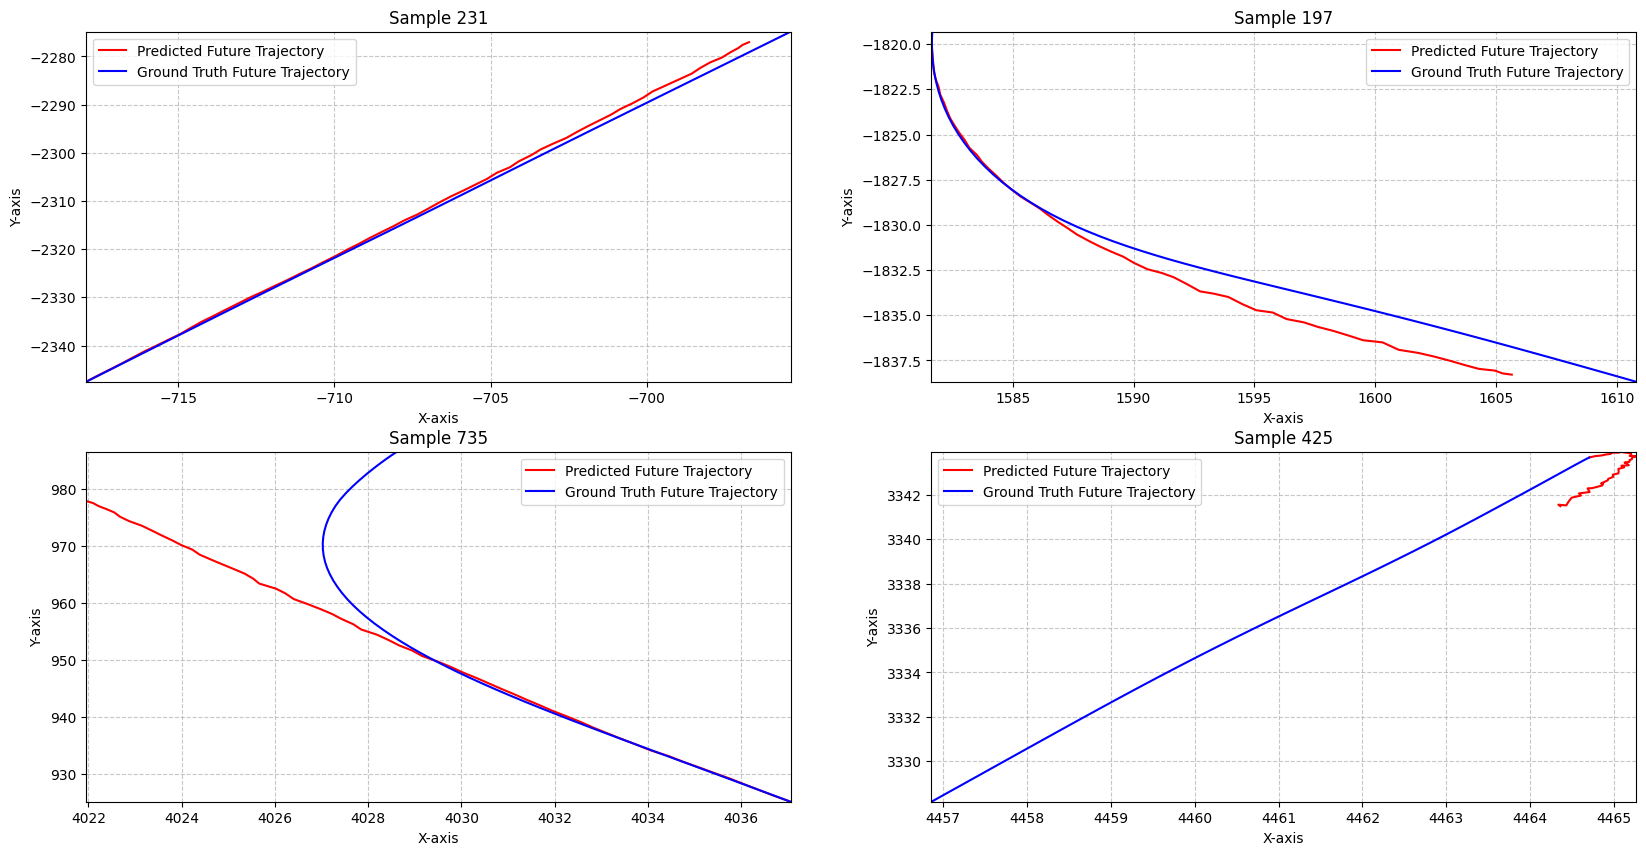

In [52]:
model.load_state_dict(torch.load("best_model.pt"))
model.eval()

# randomly select 4 samples from the validation set
random_indices = random.sample(range(len(val_dataset)), 4)
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
axes = axes.flatten()  # Flatten the array to iterate single axes objects

for i, idx in enumerate(random_indices):
    batch = val_dataset[idx]
    batch = batch.to(device)
    pred = model(batch)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0)

    pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
    gt = torch.stack(torch.split(batch.y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

    pred = pred.detach().cpu().numpy()
    gt = gt.detach().cpu().numpy()

    # Plot the trajectory using the i-th axis
    plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

plt.show()

#### Output your predictions of the best model on the test set

In [54]:
test_dataset = TrajectoryDatasetTest(test_data, scale=scale)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False,
                         collate_fn=lambda xs: Batch.from_data_list(xs))

best_model = torch.load("best_model.pt")
# model = LinearRegressionModel().to(device)
# model = MLP(50 * 50 * 6, 60 * 2).to(device)
# model = LSTM().to(device)
model = InteractionAwareLSTM().to(device)

model.load_state_dict(best_model)
model.eval()

pred_list = []
with torch.no_grad():
    for batch in test_loader:
        batch = batch.to(device)
        pred_norm = model(batch)
        
        # Reshape the prediction to (N, 60, 2)
        pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
        pred_list.append(pred.cpu().numpy())
pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
output_df.index.name = 'index'
output_df.to_csv('submission.csv', index=True)

## Step 4: Summarize your experiments and results in table and figures in the submitted PDF file for Question 3 Problem A

## Step 5: Analyze the results, identify the issues and plan for the improvement in the submitted PDF file for Question 3 Problem B